In [1]:
#!pip install nltk#\

In [6]:
import numpy as np
import pandas as pd
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report

In [3]:
!python3 -m spacy download en_core_web_lg


Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 704, in urlopen
    httplib_response = self._make_request(
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 387, in _make_request
    self._validate_conn(conn)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 1043, in _validate_conn
   

In [7]:
# Loading CSV file
df_reddit = pd.read_csv("/home/olalekan/Documents/Reddit_comment/reddit_comments - reddit.csv")

In [8]:
#Add the new column which gives a unique number to each of these labels
df_reddit['label_num'] = df_reddit['Label'].map({'Medical Doctor' : 0, 'Veterinarian':1,'Other':2})

#check the results with top 5 rows
df_reddit.head(5)

,Reddit Comment,Label,label_num
0,"Absolutely appalled by this! I'm a surgeon, an...",Medical Doctor,0
1,Anatomy of great apes and humans is very simil...,Medical Doctor,0
2,Another frustration is that residency is absol...,Medical Doctor,0
3,"As a neurologist, I know the importance of a h...",Medical Doctor,0
4,"As a practicing allergist, I understand the ch...",Medical Doctor,0


In [9]:
df_reddit.Label.value_counts()

Label
Other             433
Medical Doctor    154
Veterinarian      128
Name: count, dtype: int64

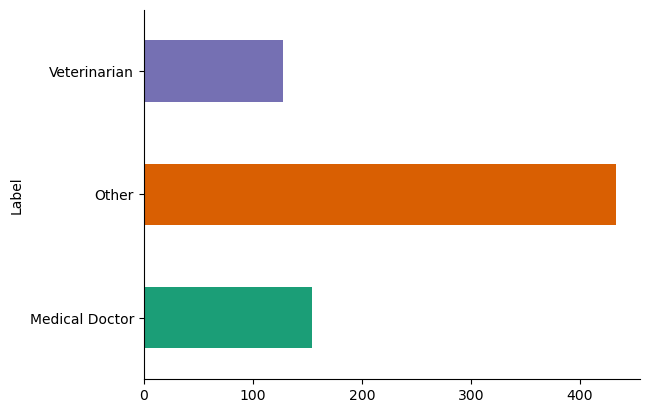

In [10]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
df_reddit.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and pre-process text data.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """

    text = text.lower()  # Lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)  # Replace special symbols with spaces
    text = BAD_SYMBOLS_RE.sub('', text)  # Remove non-alphanumeric characters (except #, +, _)
    text = text.replace('x', '')  # Remove any remaining 'x' characters (optional)


    return text

# Apply cleaning function to the 'Reddit Comment' column
df_reddit['Cleaned Comment'] = df_reddit['Reddit Comment'].apply(clean_text)

In [12]:
# Top 5 records
df_reddit.head()

,Reddit Comment,Label,label_num,Cleaned Comment
0,"Absolutely appalled by this! I'm a surgeon, an...",Medical Doctor,0,absolutely appalled by this im a surgeon and ...
1,Anatomy of great apes and humans is very simil...,Medical Doctor,0,anatomy of great apes and humans is very simil...
2,Another frustration is that residency is absol...,Medical Doctor,0,another frustration is that residency is absol...
3,"As a neurologist, I know the importance of a h...",Medical Doctor,0,as a neurologist i know the importance of a h...
4,"As a practicing allergist, I understand the ch...",Medical Doctor,0,as a practicing allergist i understand the ch...


In [13]:
# Create our list of stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text data by removing punctuation, lemmatizing, and removing stopwords.

    Args:
        text (str): The text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """

    # Load English tokenizer, tagger, parser, NER and word vectors
    parser = English()
    tokens = []

    # Tokenize the text and remove punctuation
    for token in parser(text):
        if token.is_alpha:
            tokens.append(token.lemma_.lower())

    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]

    return " ".join(cleaned_tokens)


# Apply preprocessing function to the 'Cleaned Comment' column
df_reddit['processed_text'] = df_reddit['Cleaned Comment'].apply(preprocess_text)

In [14]:
# Load the spaCy model with embeddings
nlp = spacy.load("en_core_web_lg")

def process_and_embed_data(data):
    """
    Process and embed the comments in the given dataset.

    Args:
        data (pd.Series): Series containing the comments to be processed and embedded.

    Returns:
        np.ndarray: Embedded dataset.
    """

    embedded_dataset = [nlp(comment).vector for comment in data]
    embedded_dataset = np.array(embedded_dataset)

    return embedded_dataset




In [23]:
# Process and embed the comments in the test set
embedded_dataset= process_and_embed_data(df_reddit['processed_text'])
labels = df_reddit['label_num']
train_data,test_data,train_labels,test_labels= train_test_split(embedded_dataset,labels, test_size=0.2, stratify=labels)


In [27]:
embedded_dataset

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
# Train the RandomForestClassifier with class weights
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_data,  train_labels)

# Evaluate the model
y_pred = clf.predict(test_data)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        25
           2       0.61      1.00      0.76        87

    accuracy                           0.61       143
   macro avg       0.20      0.33      0.25       143
weighted avg       0.37      0.61      0.46       143



/home/olalekan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olalekan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olalekan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  Predicting New data

In [ ]:
# Loading CSV file
new_data = pd.read_csv("/content/test - Sheet1 .csv")

In [ ]:
new_data['Cleaned Comment'] = new_data['Reddit Comment'].apply(clean_text)

In [ ]:
new_data['processed_text'] = new_data['Cleaned Comment'].apply(preprocess_text)


In [ ]:
embedded_new_test_data, new_test_labels = process_and_embed_data(new_data['processed_text'], new_data['label_num'])
